In [6]:
import os, glob, warnings, joblib, random
import numpy as np, pandas as pd
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ==== PATHS (chỉnh theo máy bạn) ====
CIC2019_DIR = r'D:\DACN\dataset\CICDDoS2019'
CIC2017_DIR = r'D:\DACN\dataset\CICDDoS2017'
UNSW15_DIR  = r'D:\DACN\dataset\UNSW_NB15'
NSLKDD_DIR  = r'D:\DACN\dataset\NSL-KDD'   # có KDDTrain+.txt, KDDTest+.txt

# ==== loại cột ID/time ====
EXCLUDE_ID_COLUMNS = True
ID_LIKE_COLS = set([
    'Flow ID','FlowID','Timestamp','StartTime','Start Time','stime','time','Date','datetime',
    'Src IP','Dst IP','Source IP','Destination IP',
    'srcip','dstip','srcip_addr','dstip_addr', 
    'Src Port','Dst Port','Sport','Dport','srcport','dstport',
    'ProtocolName','ProtoName','Service','service','state','attack_cat','label',
    'Unnamed: 0','id','No.','Index'
])
LABEL_CANDS = ["Label","label","Attack","attack","attack_cat","class","Class","target","category","Category","result"]

# kiểm soát lệch phân bố từ UNSW (toàn attack)
MAX_UNSW_RATIO = 0.30   # tối đa 30% số mẫu DDoS từ UNSW trong tập gộp (đổi nếu muốn)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [7]:
# ==== LIMIT CPU TO ~90% THREADS ====
import os, math
import multiprocessing as mp

def limit_cpu(fraction: float = 0.90) -> int:
    """
    Giới hạn tài nguyên CPU ở mức ~fraction (theo số luồng).
    Trả về số threads cho phép để dùng cho n_jobs/num_threads.
    """
    fraction = max(0.1, min(1.0, float(fraction)))
    total = os.cpu_count() or mp.cpu_count() or 1
    allow = max(1, math.floor(total * fraction))

    # 1) Đặt env vars cho các backend BLAS/OMP (hữu ích nếu import sau)
    os.environ["OMP_NUM_THREADS"] = str(allow)
    os.environ["OPENBLAS_NUM_THREADS"] = str(allow)
    os.environ["MKL_NUM_THREADS"] = str(allow)
    os.environ["VECLIB_MAXIMUM_THREADS"] = str(allow)
    os.environ["NUMEXPR_MAX_THREADS"] = str(allow)
    os.environ["NUMEXPR_NUM_THREADS"] = str(allow)

    # 2) Cưỡng chế runtime cho libs đã import (NumPy/MKL/OpenBLAS) qua threadpoolctl
    try:
        from threadpoolctl import threadpool_limits
        threadpool_limits(allow)  # áp dụng toàn cục cho tiến trình hiện tại
    except Exception:
        pass  # threadpoolctl đã là phụ thuộc của scikit-learn; nếu thiếu vẫn tiếp tục

    # 3) CPU affinity (Windows/Linux) để ghim vào N core đầu tiên
    try:
        import psutil
        p = psutil.Process()
        cpus = list(range(allow))
        # Trên Windows 10/11 và Linux đều hỗ trợ cpu_affinity trong psutil
        p.cpu_affinity(cpus)
    except Exception:
        pass

    print(f"[CPU] total={total} | allow={allow} threads (~{fraction*100:.0f}%)")
    return allow

# GỌI HÀM NÀY SỚM TRONG NOTEBOOK:
threads_allowed = limit_cpu(0.90)

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(threads_allowed)
tf.config.threading.set_inter_op_parallelism_threads(max(1, threads_allowed//2))


[CPU] total=20 | allow=18 threads (~90%)


In [8]:
def safe_read_any(path: str, nrows=None) -> pd.DataFrame:
    low = path.lower()
    try:
        if low.endswith(".parquet"):
            return pd.read_parquet(path) if nrows is None else pd.read_parquet(path).head(nrows)
        # NSL-KDD .txt không header
        if low.endswith(".txt") and ("kddtrain" in low or "kddtest" in low):
            df = pd.read_csv(path, header=None)
            if df.shape[1] == 43:
                cols = [f"feat_{i}" for i in range(41)] + ["label","difficulty"]
            elif df.shape[1] == 42:
                cols = [f"feat_{i}" for i in range(41)] + ["label"]
            else:
                cols = [f"col_{i}" for i in range(df.shape[1])]
            df.columns = cols
            return df if nrows is None else df.head(nrows)
        # csv chung
        for enc in ("utf-8-sig","utf-8","cp1252","latin1"):
            try:
                return pd.read_csv(path, encoding=enc, compression="infer", low_memory=False, nrows=nrows)
            except Exception:
                continue
        return pd.read_csv(path, compression="infer", low_memory=False, nrows=nrows)
    except Exception as e:
        print(f"[WARN] skip {os.path.basename(path)}: {e}")
        return pd.DataFrame()

def find_label_col(df: pd.DataFrame):
    for c in LABEL_CANDS:
        if c in df.columns: return c
    return None

# map AttackType như code gốc
attack_group_map = {
    'DrDoS_DNS':'DrDoS','DrDoS_SNMP':'DrDoS','DrDoS_NTP':'DrDoS','DrDoS_MSSQL':'DrDoS',
    'DrDoS_SSDP':'DrDoS','DrDoS_UDP':'DrDoS','TFTP':'TFTP',
    'UDP':'UDP','UDPLag':'UDP','Syn':'Syn','MSSQL':'MSSQL','LDAP':'LDAP',
    'DoS slowloris':'DoS','DoS Slowhttptest':'DoS','DoS Hulk':'DoS','DoS GoldenEye':'DoS',
    'Heartbleed':'Other',
    'Web Attack � Brute Force':'Web Attack','Web Attack � XSS':'Web Attack','Web Attack � Sql Injection':'Web Attack',
    'FTP-Patator':'Brute Force','SSH-Patator':'Brute Force','Infiltration':'Other','Bot':'Other',
    'PortScan':'PortScan','NetBIOS':'Other'
}

def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    lbl = find_label_col(df)
    if lbl is None:
        return pd.DataFrame()  # bỏ file không có nhãn
    df.rename(columns={lbl: "Label"}, inplace=True)
    df["Label"] = df["Label"].astype(str).str.strip()
    df.loc[df["Label"].str.lower().isin(["normal","benign","non-attack","good"]), "Label"] = "Benign"
    if "AttackType" not in df.columns:
        df["AttackType"] = df["Label"]
    def group_attack_type(x):
        if pd.isna(x): return 'Other'
        if x == 'Benign': return 'Benign'
        return attack_group_map.get(str(x), 'Other')
    df["AttackType"] = df["AttackType"].apply(group_attack_type)
    df["Label"] = df["Label"].apply(lambda v: 'Benign' if str(v)=='Benign' else 'DDoS')
    return df


In [9]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: chỉ lấy các file có nhãn (bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv)
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL (txt):", len(nsl_files))

# union numeric + dataset_id
def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: 
            continue
        head = normalize_labels(head)
        if head.empty: 
            continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, "feature_order_union.pkl")


CIC19 train: 7 CIC19 test: 10
CIC17: 8 UNSW: 6 NSL (txt): 4
Tổng số cột numeric union: 156


['feature_order_union.pkl']

In [10]:
def load_and_normalize(files: List[str], dataset_id: int) -> pd.DataFrame:
    out = []
    for p in tqdm(files, desc=f"Load ds{dataset_id}"):
        df = safe_read_any(p)
        if df.empty: 
            continue
        df = normalize_labels(df)
        if df.empty:
            continue
        df["dataset_id"] = dataset_id
        out.append(df)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

df17  = load_and_normalize(cic17_files, 1)
df19t = load_and_normalize(cic19_train, 2)
df19e = load_and_normalize(cic19_test, 2)    # chỉ để thống kê/valid nếu cần
dfUN  = load_and_normalize(unsw_files, 3)
dfNSL = load_and_normalize(nsl_files, 4)

print("Shapes:", {k:v.shape for k,v in {"CIC17":df17,"CIC19_train":df19t,"UNSW":dfUN,"NSL":dfNSL}.items()})

# gộp chính (CIC-2017 + CIC-2019 train)
df_main = pd.concat([df17, df19t], ignore_index=True)

# hạn chế UNSW (toàn attack) để không lấn át -> MAX_UNSW_RATIO * tổng DDoS hiện có
if not dfUN.empty:
    cur_ddos = (df_main["Label"]=="DDoS").sum()
    cap = int(MAX_UNSW_RATIO * max(1, cur_ddos))
    dfUN_ddos = dfUN[dfUN["Label"]=="DDoS"]
    if len(dfUN_ddos) > cap:
        dfUN_ddos = dfUN_ddos.sample(cap, random_state=RANDOM_STATE)
    dfUN = dfUN_ddos  # UNSW gần như toàn DDoS

# thêm NSL (có cả benign/attack)
df_all = pd.concat([df_main, dfUN, dfNSL], ignore_index=True)
assert not df_all.empty, "Không có dữ liệu!"

# thay NaN/Inf
df_all = df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
print("Tổng mẫu sau gộp:", df_all.shape)
for c in df_all.columns:
    if df_all[c].dtype == "object":
        df_all[c] = df_all[c].astype(str)
#lưu
df_all.to_parquet("df_all_union.parquet", index=False)

# --- Đọc lại ---
import pandas as pd
df_all = pd.read_parquet("df_all_union.parquet")

print("Đọc lại thành công:", df_all.shape)


Load ds4: 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


Shapes: {'CIC17': (2313810, 80), 'CIC19_train': (125170, 80), 'UNSW': (257673, 47), 'NSL': (185559, 45)}
Tổng mẫu sau gộp: (2749109, 166)
Đọc lại thành công: (2749109, 166)


In [11]:
# chọn numeric union
drop_cols = {'Label','AttackType'}
if EXCLUDE_ID_COLUMNS:
    drop_cols |= {c for c in df_all.columns if c in ID_LIKE_COLS}
feature_candidates = [c for c in FEATURES if c not in drop_cols and c in df_all.columns]
print("Số cột dùng:", len(feature_candidates))

X = df_all.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
y_bin = (df_all['Label'] != 'Benign').astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bin
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

# scaler + SMOTE như gốc
scaler = MinMaxScaler()
scaler.fit(X_train_raw.values)
joblib.dump(scaler, 'scaler_union.pkl')

X_train_s = scaler.transform(X_train_raw.values)
X_test_s  = scaler.transform(X_test_raw.values)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_s, y_train)
print("After SMOTE:", X_res.shape, "| pos_ratio:", y_res.mean().round(4))


Số cột dùng: 156
Train: (2199287, 156) Test: (549822, 156)
After SMOTE: (3386240, 156) | pos_ratio: 0.5


[✓] Epoch 1/3 — best_iter: 500
[✓] Epoch 2/3 — best_iter: 542
[✓] Epoch 3/3 — best_iter: 542


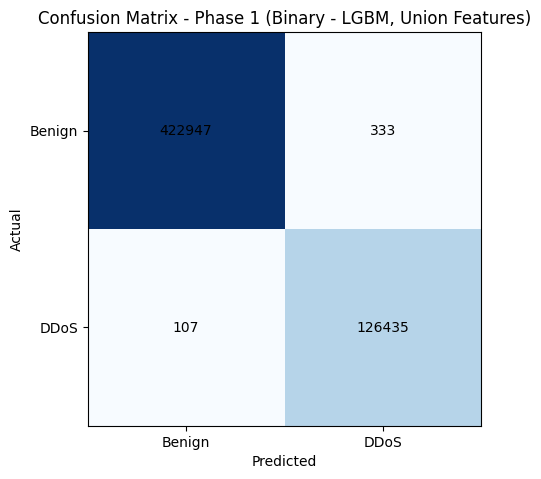

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999899031971388


In [12]:
# bạn có thể tăng n_estimators từng "epoch" để nhẹ hơn
EPOCHS = 3
ROUND_PER_EPOCH = 500   # mỗi epoch tăng thêm 500 cây

clf_bin = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight='balanced',
    n_estimators=ROUND_PER_EPOCH,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1,
    # warm_start cho phép tăng n_estimators dần
    warm_start=True
)

for e in range(EPOCHS):
    clf_bin.n_estimators = (e+1)*ROUND_PER_EPOCH
    clf_bin.fit(
        X_res, y_res,
        eval_set=[(X_test_s, y_test)],
        eval_metric=['auc','binary_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    print(f"[✓] Epoch {e+1}/{EPOCHS} — best_iter: {clf_bin.best_iteration_}")

joblib.dump({'model': clf_bin, 'scaler': scaler, 'feature_order': feature_candidates},
            'lgbm_binary_union.joblib')

# đánh giá
y_prob = clf_bin.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
for (i,j),v in np.ndenumerate(cm): plt.text(j,i,str(v),ha="center",va="center")
plt.xticks([0,1],["Benign","DDoS"]); plt.yticks([0,1],["Benign","DDoS"])
plt.title("Confusion Matrix - Phase 1 (Binary - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred, target_names=['Benign','DDoS']))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Classes: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']


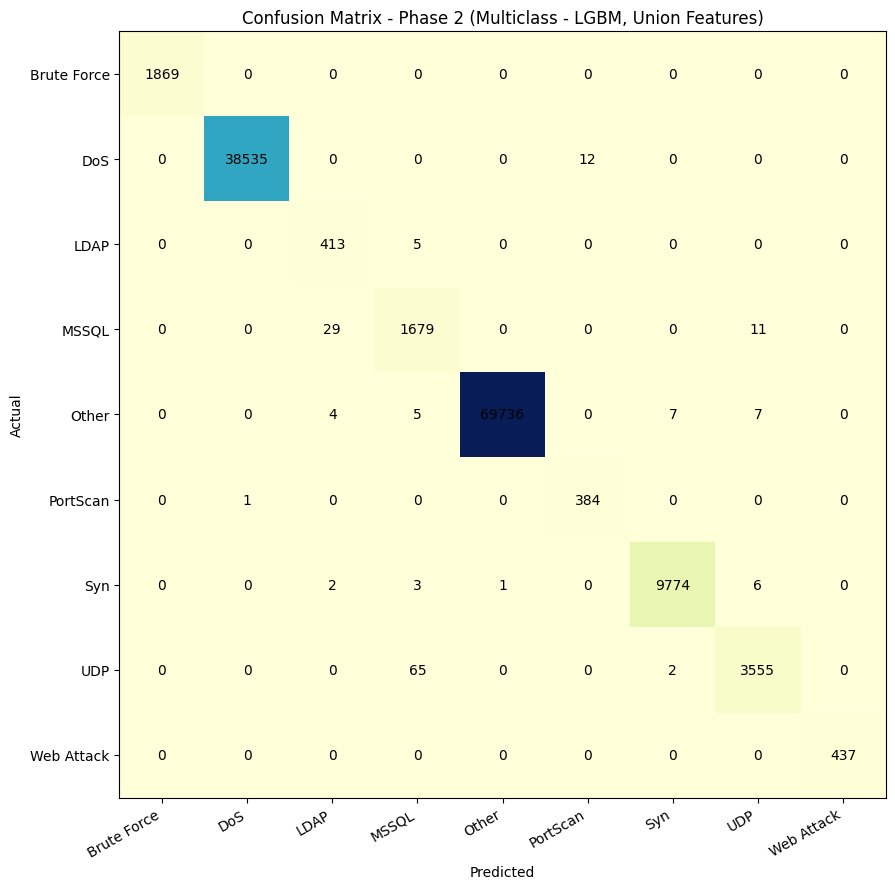

              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00      1869
         DoS       1.00      1.00      1.00     38547
        LDAP       0.92      0.99      0.95       418
       MSSQL       0.96      0.98      0.97      1719
       Other       1.00      1.00      1.00     69759
    PortScan       0.97      1.00      0.98       385
         Syn       1.00      1.00      1.00      9786
         UDP       0.99      0.98      0.99      3622
  Web Attack       1.00      1.00      1.00       437

    accuracy                           1.00    126542
   macro avg       0.98      0.99      0.99    126542
weighted avg       1.00      1.00      1.00    126542



In [14]:
# lấy toàn bộ mẫu DDoS
df_attack = df_all[df_all['Label']=='DDoS'].copy()
X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32).values
X_attack_s = scaler.transform(X_attack)

# nhãn đa lớp
y_attack_txt = df_attack['AttackType'].astype(str).values
le_attack = LabelEncoder()
y_attack = le_attack.fit_transform(y_attack_txt)
n_classes = len(le_attack.classes_)
joblib.dump(le_attack, "attack_label_encoder_union.pkl")
print("Classes:", list(le_attack.classes_))

# SMOTE đa lớp
X_attack_res, y_attack_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_attack_s, y_attack)

# chia train/test theo stratified
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_attack_res, y_attack_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack_res
)

# trọng số theo tần suất đảo để ổn định hơn
counts = pd.Series(ya_tr).value_counts()
inv_ratio = counts.max() / counts
sample_weight = pd.Series(ya_tr).map(inv_ratio).values

clf_multi = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    n_estimators=1600,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

clf_multi.fit(
    Xa_tr, ya_tr,
    sample_weight=sample_weight,
    eval_set=[(Xa_te, ya_te)],
    eval_metric=['multi_logloss'],
    callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
)

joblib.dump({
    'model': clf_multi,
    'scaler': scaler,
    'feature_order': feature_candidates,
    'attack_label_encoder': le_attack
}, 'lgbm_attack_union.joblib')

# Đánh giá trên phần DDoS thuộc tập test của Cell 5
test_mask_ddos = (y_test == 1)
X_attack_test = X_test_s[test_mask_ddos]
y_attack_test_txt = df_all.iloc[X_test_raw.index][test_mask_ddos]['AttackType'].astype(str).values  # tương ứng order

# map nhãn test -> encoder
y_attack_test = []
for t in y_attack_test_txt:
    if t in le_attack.classes_:
        y_attack_test.append(le_attack.transform([t])[0])
    else:
        # nếu có nhãn lạ → gộp "Other" nếu tồn tại, ngược lại bỏ
        if "Other" in le_attack.classes_:
            y_attack_test.append(le_attack.transform(["Other"])[0])
        else:
            # bỏ trường hợp hiếm không map được
            y_attack_test.append(-1)
y_attack_test = np.array([v for v in y_attack_test if v >= 0])

# dự đoán
y_attack_pred = clf_multi.predict(X_attack_test[:len(y_attack_test)])

labels_multi = le_attack.classes_
cm2 = confusion_matrix(y_attack_test, y_attack_pred)
plt.figure(figsize=(12,9))
plt.imshow(cm2, cmap='YlGnBu')
for (i,j),v in np.ndenumerate(cm2): plt.text(j,i,str(v),ha="center",va="center")
plt.xticks(range(len(labels_multi)), labels_multi, rotation=30, ha="right")
plt.yticks(range(len(labels_multi)), labels_multi)
plt.title("Confusion Matrix - Phase 2 (Multiclass - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_attack_test, y_attack_pred, target_names=labels_multi))


In [15]:
import time, numpy as np, pandas as pd
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, accuracy_score
)

RESULTS_BIN = []  # lưu so sánh phase-1

def eval_binary(y_true, y_prob, name, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    RESULTS_BIN.append({"Model": name, "ACC": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc})
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=["Benign","DDoS"]))
    print("ROC-AUC:", auc)
    return y_pred

# dữ liệu cho DL (coi mỗi feature là 1 “time step”)
X_train_dl = X_res.astype(np.float32).reshape(-1, X_res.shape[1], 1)
X_test_dl  = X_test_s.astype(np.float32).reshape(-1, X_test_s.shape[1], 1)
y_train_dl = y_res.astype(np.int32)
y_test_dl  = y_test.astype(np.int32)

print("DL shapes:", X_train_dl.shape, X_test_dl.shape)


DL shapes: (3386240, 156, 1) (549822, 156, 1)



# IDS — Dùng **tất cả đặc trưng** (union 4 bộ dữ liệu) với XGBoost & RandomForest

- Bộ dữ liệu: **CICDDoS2017 + CICDDoS2019 (chính)**, kèm **KDD99 & UNSW-NB15**
- Model: **XGBoost & RandomForest**


In [16]:
# === Phase-1: XGBoost (binary) + RandomForest — compatible all versions ===
import time, numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from packaging import version
from sklearn.ensemble import RandomForestClassifier

# cap số mẫu cho tree models
MAX_TRAIN_SAMPLES_TREE = 1_000_000
rng = np.random.RandomState(42)
idx = rng.choice(len(X_res), size=min(MAX_TRAIN_SAMPLES_TREE, len(X_res)), replace=False)
X_tree = X_res[idx]; y_tree = y_res[idx]

print(f"[INFO] xgboost version: {xgb.__version__}")
xgb_bin = XGBClassifier(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0,
    tree_method="hist", n_jobs=-1, random_state=42,
    eval_metric="auc"   # đặt ở constructor (ổn cho cả 1.x và 2.x)
)

t0 = time.time()
# Một số bản không hỗ trợ callbacks/early_stopping trong .fit() của sklearn wrapper
try:
    # thử dùng callbacks nếu bản hiện tại có
    from xgboost import callback as xgb_cb
    early_cbs = [xgb_cb.EarlyStopping(rounds=50, metric_name="auc", maximize=True)]
    xgb_bin.fit(X_tree, y_tree, eval_set=[(X_test_s, y_test)], callbacks=early_cbs)
except TypeError:
    # fallback: không callbacks, chỉ theo n_estimators
    xgb_bin.fit(X_tree, y_tree, eval_set=[(X_test_s, y_test)], verbose=False)
print(f"XGBoost train time: {time.time()-t0:.1f}s")

yprob_xgb = xgb_bin.predict_proba(X_test_s)[:, 1]
eval_binary(y_test, yprob_xgb, "XGBoost (Binary)")

# ----- Random Forest (Binary) -----
rf_bin = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    class_weight="balanced_subsample", n_jobs=-1, random_state=42
)
t0 = time.time()
rf_bin.fit(X_tree, y_tree)
print(f"RF train time: {time.time()-t0:.1f}s")
yprob_rf = rf_bin.predict_proba(X_test_s)[:, 1]
eval_binary(y_test, yprob_rf, "RandomForest (Binary)")


NameError: name 'X_res' is not defined

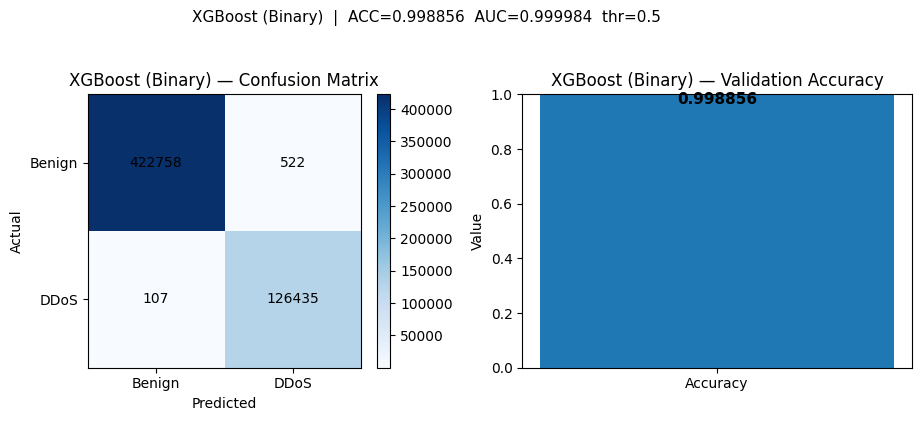

XGBoost (Binary) — Validation Accuracy: 0.998856



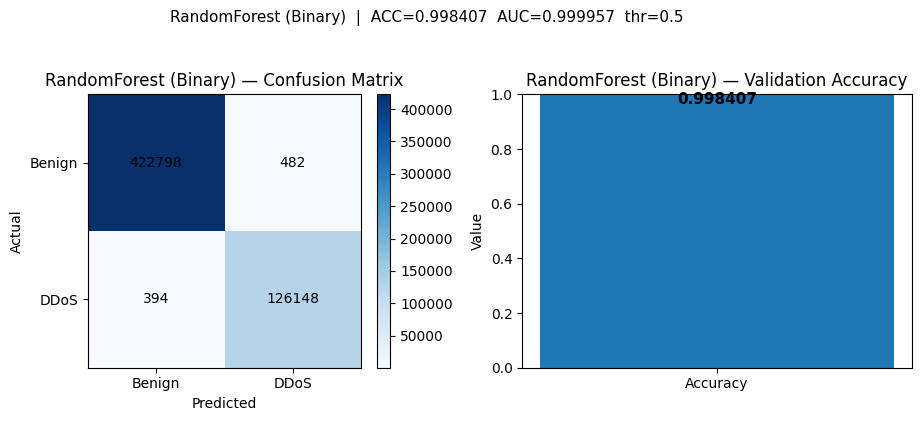

RandomForest (Binary) — Validation Accuracy: 0.998407



In [17]:
# === Plot per-model: Confusion Matrix + Validation Accuracy ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

def show_cm_and_valacc(model_name, y_true, y_prob, threshold=0.5, savepath=None):
    y_pred = (y_prob >= threshold).astype(int)
    cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    # Confusion matrix
    im = axes[0].imshow(cm, cmap="Blues")
    for (i,j),v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=10)
    axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["Benign","DDoS"])
    axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["Benign","DDoS"])
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    # Validation Accuracy bar
    axes[1].bar([0], [acc], width=0.5)
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.6f}", ha="center",
                 va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.6f}  AUC={auc:.6f}  thr={threshold}", y=1.04, fontsize=11)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"{model_name} — Validation Accuracy: {acc:.6f}\n")

# --- gọi cho từng model đã train ---
# dùng ngưỡng 0.5; nếu bạn có best_thr thì đổi threshold=best_thr
show_cm_and_valacc("XGBoost (Binary)",      y_test, yprob_xgb, threshold=0.5)
show_cm_and_valacc("RandomForest (Binary)", y_test, yprob_rf,  threshold=0.5)

# (tuỳ chọn) thêm LightGBM / LSTM / GRU / CNN / Autoencoder nếu đã train:
# yprob_lgb = clf_bin.predict_proba(X_test_s)[:,1]
# show_cm_and_valacc("LightGBM (Binary)", y_test, yprob_lgb, threshold=0.5)
# show_cm_and_valacc("LSTM (Binary)",     y_test, yprob_lstm, threshold=0.5)
# show_cm_and_valacc("GRU (Binary)",      y_test, yprob_gru,  threshold=0.5)
# show_cm_and_valacc("1D-CNN (Binary)",   y_test, yprob_cnn,  threshold=0.5)
# show_cm_and_valacc("Autoencoder",       y_test, yprob_ae,   threshold=0.5)


In [ ]:
# === Phase 2 — XGBoost (Multiclass AttackType, RAM-optimized) ===
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np, joblib
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

print("\n=== Phase 2 — XGBoost (Multiclass AttackType) ===")

# --- Chuẩn bị dữ liệu DDoS ---
df_attack = df_all[df_all["Label"] == "DDoS"].copy()
X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
X_attack_s = scaler.transform(X_attack)

# Mã hoá nhãn AttackType
y_attack_txt = df_attack["AttackType"].astype(str).values
le_attack = LabelEncoder()
y_attack = le_attack.fit_transform(y_attack_txt)
num_classes = len(le_attack.classes_)
print("Attack classes:", list(le_attack.classes_))

# --- Áp dụng SMOTE nhẹ (sampling_strategy giảm để tiết kiệm RAM) ---
sm = SMOTE(
    sampling_strategy="auto",   # auto = cân bằng tất cả các lớp đa nhãn
    random_state=RANDOM_STATE
)

print("[SMOTE] Fitting... (this may take ~1-2 mins)")
X_attack_res, y_attack_res = sm.fit_resample(X_attack_s.astype(np.float32), y_attack)
print("[SMOTE] Done. New shape:", X_attack_res.shape)

# --- Chuyển sang float16 để giảm dung lượng ---
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_attack_res, y_attack_res, test_size=0.2,
    stratify=y_attack_res, random_state=RANDOM_STATE
)
Xa_tr = Xa_tr.astype(np.float16)
Xa_te = Xa_te.astype(np.float16)
print("Train:", Xa_tr.shape, "Test:", Xa_te.shape)

# --- Train mô hình XGBoost (multi:softprob) ---
xgb_multi = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=500,           # giảm số cây (1200 → 500)
    max_depth=7,                # giảm độ sâu (8 → 7)
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",         # rất quan trọng để giảm RAM
    predictor="auto",
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

print("[XGBoost] Training...")
xgb_multi.fit(Xa_tr, ya_tr, eval_set=[(Xa_te, ya_te)], verbose=False)
print("[XGBoost] Done.")

# --- Lưu mô hình ---
joblib.dump({
    "model": xgb_multi,
    "encoder": le_attack,
    "scaler": scaler,
    "features": feature_candidates
}, "xgb_attack_union.joblib")

# --- Đánh giá ---
ya_pred = xgb_multi.predict(Xa_te)
print("\n=== Classification Report (Phase 2 — XGBoost) ===")
print(classification_report(ya_te, ya_pred, target_names=le_attack.classes_))


Loaded df_all: (2749109, 166)
Filtered DDoS subset: (632709, 166)


NameError: name 'feature_candidates' is not defined

[Saved] results/xgb_attack_confmatrix.png


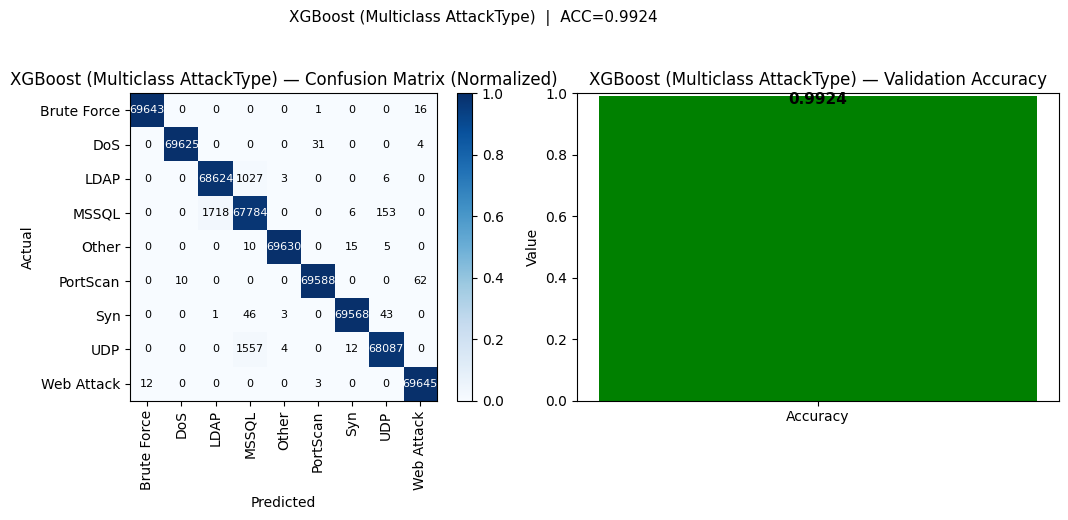

XGBoost (Multiclass AttackType) — Validation Accuracy: 0.992427



In [32]:
# === Phase 2 — Plot Confusion Matrix + Validation Accuracy ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def show_cm_and_valacc_multiclass(model_name, y_true, y_pred, labels, savepath=None):
    # --- Accuracy ---
    acc = accuracy_score(y_true, y_pred)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix (Normalized)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    im = axes[0].imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
    for (i, j), v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=8,
                     color="white" if cm_norm[i, j] > 0.5 else "black")
    axes[0].set_xticks(np.arange(len(labels))); axes[0].set_xticklabels(labels, rotation=90)
    axes[0].set_yticks(np.arange(len(labels))); axes[0].set_yticklabels(labels)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix (Normalized)")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    # Validation Accuracy bar
    axes[1].bar([0], [acc], width=0.5, color="green")
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.4f}", ha="center",
                 va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.4f}", y=1.03, fontsize=11)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
        print(f"[Saved] {savepath}")

    plt.show()
    print(f"{model_name} — Validation Accuracy: {acc:.6f}\n")

# --- Gọi hàm ---
show_cm_and_valacc_multiclass(
    "XGBoost (Multiclass AttackType)",
    ya_te, ya_pred,
    labels=le_attack.classes_,
    savepath="results/xgb_attack_confmatrix.png"
)


In [4]:
# === Phase 2 — RandomForest (Multiclass AttackType, RAM-optimized) ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib, numpy as np

RANDOM_STATE = 42  # hoặc cùng giá trị với cell XGBoost trước đó

print("\n=== Phase 2 — RandomForest (Multiclass AttackType, RAM-optimized) ===")

rf_multi = RandomForestClassifier(
    n_estimators=300,              # 600 -> 300
    max_depth=14,                  # giới hạn độ sâu
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced_subsample",
    n_jobs=8,
    random_state=RANDOM_STATE,
    verbose=1
)

print("[RandomForest] Training...")
rf_multi.fit(Xa_tr, ya_tr)
print("[RandomForest] Done.")

ya_pred_rf = rf_multi.predict(Xa_te)

print("\n=== Classification Report (RandomForest — Multiclass) ===")
print(classification_report(ya_te, ya_pred_rf, target_names=le_attack.classes_))

joblib.dump({
    "model": rf_multi,
    "encoder": le_attack,
    "scaler": scaler,
    "features": feature_candidates
}, "rf_attack_union.joblib")



=== Phase 2 — Multiclass AttackType ===


NameError: name 'df_all' is not defined

In [ ]:
# === Plot Confusion Matrix + Accuracy cho Multiclass ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def show_cm_multiclass(model_name, y_true, y_pred, labels, savepath=None):
    acc = accuracy_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    im = axes[0].imshow(cm, cmap="YlGnBu")
    for (i,j),v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=8)
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=30, ha="right", fontsize=8)
    axes[0].set_yticks(range(len(labels)))
    axes[0].set_yticklabels(labels, fontsize=8)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    # Accuracy bar
    axes[1].bar([0], [acc], width=0.5, color="steelblue")
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.6f}", ha="center",
                 va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.6f}", y=1.04, fontsize=11)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=140, bbox_inches="tight")
    plt.show()

    print(f"{model_name} — Accuracy: {acc:.6f}\n")



# IDS — Dùng **tất cả đặc trưng** (union 4 bộ dữ liệu) với LSMT & GRU & 1D-CNN

- Bộ dữ liệu: **CICDDoS2017 + CICDDoS2019 (chính)**, kèm **KDD99 & UNSW-NB15**
- Model: **LSMT & GRU & 1D-CNN** (nhanh & chính xác cho tabular)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore

EPOCHS_DL = 20
BATCH = 2048

cb = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_auc", mode="max"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
]

def compile_binary(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

# ----- LSTM -----
lstm = models.Sequential([
    layers.Input(shape=(X_train_dl.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
compile_binary(lstm)
hist = lstm.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
                validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=0)
yprob_lstm = lstm.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
eval_binary(y_test, yprob_lstm, "LSTM (Binary)")

# ----- GRU -----
gru = models.Sequential([
    layers.Input(shape=(X_train_dl.shape[1], 1)),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
compile_binary(gru)
hist = gru.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
               validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=0)
yprob_gru = gru.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
eval_binary(y_test, yprob_gru, "GRU (Binary)")

# ----- 1D-CNN -----
cnn = models.Sequential([
    layers.Input(shape=(X_train_dl.shape[1], 1)),
    layers.Conv1D(64, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
compile_binary(cnn)
hist = cnn.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
               validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=0)
yprob_cnn = cnn.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
eval_binary(y_test, yprob_cnn, "1D-CNN (Binary)")


NameError: name 'X_train_dl' is not defined

In [ ]:
# === Phase 2 — Deep Learning (Multiclass AttackType) ===
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import joblib

print("\n=== Phase 2 — Deep Learning (Multiclass AttackType) ===")

EPOCHS_DL = 25
BATCH = 2048
num_classes = len(le_attack.classes_)
print("Attack classes:", list(le_attack.classes_))

# reshape dữ liệu (mỗi feature = 1 "time step")
Xa_tr_dl = Xa_tr.astype(np.float32).reshape(-1, Xa_tr.shape[1], 1)
Xa_te_dl = Xa_te.astype(np.float32).reshape(-1, Xa_te.shape[1], 1)

cb = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5)
]


In [ ]:
# --------------------------------------------------
# 🧠 LSTM (Multiclass)
# --------------------------------------------------
lstm_multi = models.Sequential([
    layers.Input(shape=(Xa_tr.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
lstm_multi.compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

print("\n[Train] LSTM (Multiclass AttackType)")
lstm_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL, batch_size=BATCH,
               validation_data=(Xa_te_dl, ya_te), callbacks=cb, verbose=1)

y_pred_lstm = np.argmax(lstm_multi.predict(Xa_te_dl, batch_size=BATCH, verbose=0), axis=1)

print("\nLSTM (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_lstm))
print(classification_report(ya_te, y_pred_lstm, target_names=le_attack.classes_))

joblib.dump({
    "model": lstm_multi,
    "encoder": le_attack,
    "features": feature_candidates
}, "lstm_attack_union.joblib")
# --------------------------------------------------
# 🧠 LSTM (Multiclass)
# --------------------------------------------------
lstm_multi = models.Sequential([
    layers.Input(shape=(Xa_tr.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
lstm_multi.compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

print("\n[Train] LSTM (Multiclass AttackType)")
lstm_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL, batch_size=BATCH,
               validation_data=(Xa_te_dl, ya_te), callbacks=cb, verbose=1)

y_pred_lstm = np.argmax(lstm_multi.predict(Xa_te_dl, batch_size=BATCH, verbose=0), axis=1)

print("\nLSTM (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_lstm))
print(classification_report(ya_te, y_pred_lstm, target_names=le_attack.classes_))

joblib.dump({
    "model": lstm_multi,
    "encoder": le_attack,
    "features": feature_candidates
}, "lstm_attack_union.joblib")


In [ ]:
# --------------------------------------------------
# ⚙️ GRU (Multiclass)
# --------------------------------------------------
gru_multi = models.Sequential([
    layers.Input(shape=(Xa_tr.shape[1], 1)),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
gru_multi.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

print("\n[Train] GRU (Multiclass AttackType)")
gru_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL, batch_size=BATCH,
              validation_data=(Xa_te_dl, ya_te), callbacks=cb, verbose=1)

y_pred_gru = np.argmax(gru_multi.predict(Xa_te_dl, batch_size=BATCH, verbose=0), axis=1)

print("\nGRU (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_gru))
print(classification_report(ya_te, y_pred_gru, target_names=le_attack.classes_))

joblib.dump({
    "model": gru_multi,
    "encoder": le_attack,
    "features": feature_candidates
}, "gru_attack_union.joblib")


In [ ]:
# --------------------------------------------------
# ⚡ 1D-CNN (Multiclass)
# --------------------------------------------------
cnn_multi = models.Sequential([
    layers.Input(shape=(Xa_tr.shape[1], 1)),
    layers.Conv1D(64, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
cnn_multi.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

print("\n[Train] 1D-CNN (Multiclass AttackType)")
cnn_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL, batch_size=BATCH,
              validation_data=(Xa_te_dl, ya_te), callbacks=cb, verbose=1)

y_pred_cnn = np.argmax(cnn_multi.predict(Xa_te_dl, batch_size=BATCH, verbose=0), axis=1)

print("\n1D-CNN (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_cnn))
print(classification_report(ya_te, y_pred_cnn, target_names=le_attack.classes_))

joblib.dump({
    "model": cnn_multi,
    "encoder": le_attack,
    "features": feature_candidates
}, "cnn_attack_union.joblib")


In [ ]:
# --------------------------------------------------
# === Plot Confusion Matrix + Accuracy (Multiclass) ===
# --------------------------------------------------
def show_cm_multiclass(model_name, y_true, y_pred, labels, savepath=None):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    im = axes[0].imshow(cm, cmap="YlGnBu")
    for (i,j),v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=7)
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=30, ha="right", fontsize=7)
    axes[0].set_yticks(range(len(labels)))
    axes[0].set_yticklabels(labels, fontsize=7)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].bar([0], [acc], width=0.5, color="steelblue")
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.6f}",
                 ha="center", va="center", fontsize=11, fontweight="bold")
    axes[1].set_title(f"{model_name} — Validation Accuracy")

    plt.suptitle(f"{model_name}  |  ACC={acc:.6f}", y=1.04, fontsize=11)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"{model_name} — Accuracy: {acc:.6f}\n")


# Hiển thị kết quả cho 3 model
show_cm_multiclass("LSTM (Multiclass AttackType)", ya_te, y_pred_lstm, list(le_attack.classes_))
show_cm_multiclass("GRU (Multiclass AttackType)",  ya_te, y_pred_gru,  list(le_attack.classes_))
show_cm_multiclass("1D-CNN (Multiclass AttackType)", ya_te, y_pred_cnn, list(le_attack.classes_))


In [ ]:
# chuẩn bị dữ liệu benign-only
X_train_benign = X_train_s[y_train==0].astype(np.float32)
X_test_s32 = X_test_s.astype(np.float32)

ae = models.Sequential([
    layers.Input(shape=(X_train_benign.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(X_train_benign.shape[1], activation=None)
])
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
ae.fit(X_train_benign, X_train_benign, epochs=20, batch_size=2048,
       validation_split=0.1, callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)], verbose=0)

# lỗi tái tạo
recon_train = np.mean((X_train_benign - ae.predict(X_train_benign, batch_size=4096, verbose=0))**2, axis=1)
thr = float(np.percentile(recon_train, 95))  # ngưỡng P95
recon_test  = np.mean((X_test_s32 - ae.predict(X_test_s32, batch_size=4096, verbose=0))**2, axis=1)

# AE coi "lỗi cao" là DDoS
yprob_ae = (recon_test - recon_test.min()) / (recon_test.max()-recon_test.min() + 1e-12)  # chuẩn hoá để tính AUC
ypred_ae = (recon_test >= thr).astype(int)
eval_binary(y_test, yprob_ae, f"Autoencoder (thr@P95={thr:.4g})")


In [ ]:
df_cmp = pd.DataFrame(RESULTS_BIN).sort_values("AUC", ascending=False)
display(df_cmp.style.format({"ACC":"{:.4f}","Precision":"{:.4f}","Recall":"{:.4f}","F1":"{:.4f}","AUC":"{:.5f}"}))
